# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import pickle

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, generate_init


from agent import Person

from model import VirusModel, VirusModel_baseline




## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [3]:
# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# plt.show()

In [4]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [5]:
    
X, y = generate_init(train_clf = True, n = 10000)

X = pd.DataFrame(X)
y = pd.DataFrame(y)
y=y.rename(columns = {0:'y'})
df = pd.concat([X,y], axis =1)


    

In [6]:
# # Separate majority and minority classes
# df_majority = df[df['y'] ==0]
# df_minority = df[df['y'] ==1]

# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                 replace=False,    
#                                 n_samples=400)#Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                 replace=True,     
#                                 n_samples=400)# Combine minority class with downsampled majority class
# df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled])



# cv = KFold(n_splits=10)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# pipe = make_pipeline(StandardScaler(),  MLPClassifier(solver='adam', alpha = 0.001, hidden_layer_sizes=(30, 10), random_state=1)) # BaggingClassifier(estimator=SVC(class_weight={0:0.50, 1:0.50}),n_estimators=10, random_state=0))
# pipe.fit(X_train, y_train) 

# # clf = RandomForestClassifier(n_estimators=500)
# # clf.fit(X_train, y_train)
# # score = cross_val_score(pipe, X_train, y_train, cv=cv)
# print(pipe.score(X_test,y_test))

# pipe.predict(X_test)

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.624


array([1, 0, 0, ..., 0, 0, 0])

In [8]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':200,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': None
    
}
sample = ap.Sample(parameters, n=1)
model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =10, record = True)
results_baseline = exp.run() 

with open("data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']



Scheduled runs: 10


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6136


In [ ]:
def viz(data, x, y,hue):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue)
    plt.ylim([0,1])
    plt.show()

In [ ]:
df_baseline['misclassifications'] = (df_baseline['fraud'] - df_baseline['fraud_pred'])
df_baseline[df_baseline['fraud_pred'] ==-1]

wealth  fraud_pred  fraud  race  gender  convicted  \
iteration obj_id t                                                         
0         1      0  0.221997          -1      0     0       0          0   
          2      0  0.224022          -1      0     0       1          0   
          3      0  1.000000          -1      1     0       1          0   
          4      0  0.278677          -1      1     0       0          0   
          5      0  0.407557          -1      1     1       1          0   
...                      ...         ...    ...   ...     ...        ...   
9         496    0  0.098516          -1      0     0       1          0   
          497    0  0.280027          -1      1     1       1          0   
          498    0  0.005398          -1      1     0       0          0   
          499    0  0.098516          -1      0     0       1          0   
          500    0  0.098516          -1      1     0       1          0   

                    misclassifications  
iteration obj_id t                      
0         1      0                   1  
          2      0                   1  
          3      0                   2  
          4      0                   2  
          5      0                   2  
...                                ...  
9         496    0                   1  
          497    0                   2  
          498    0                   2  
          499    0                   1  
          500    0                   2  

[5000 rows x 7 columns]

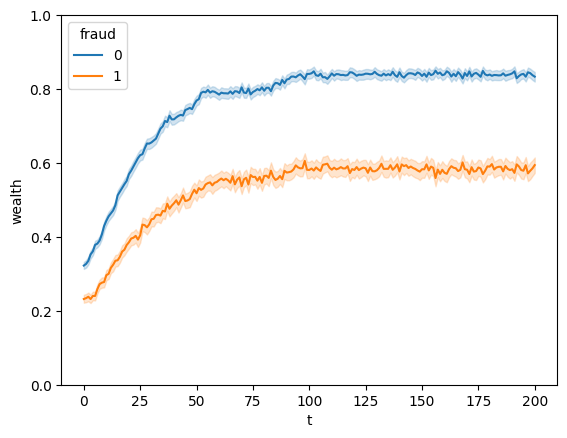

In [ ]:
viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'], df_baseline['fraud']) #, df_baseline['convicted'])

# viz(df_baseline, df_baseline.index.get_level_values('t'), abs(df_baseline['fraud'] - df_baseline['fraud_pred']), df_baseline['race'])#, df_baseline['fraud'])

In [ ]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0
df_baseline.head(400)
baseline1
# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




# df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
# df_wb0 = df_x0['wealth'] - baseline0['wealth']
# df_x0['wealth'] = df_wb0

# df_xb = pd.concat([df_x0, df_x1])

# df_xb

,wealth,fraud_pred,fraud,race,gender,convicted
t,,,,,,
1,0.00423,1.0,0.672566,0.362832,0.477876,-0.327434
2,0.00000,1.0,0.575221,0.362832,0.477876,-0.424779
3,0.00000,1.0,0.610619,0.362832,0.477876,-0.389381
4,0.00000,1.0,0.601770,0.362832,0.477876,-0.398230
5,0.00000,1.0,0.557522,0.362832,0.477876,-0.442478
...,...,...,...,...,...,...
96,0.00000,1.0,0.637168,0.362832,0.477876,-0.362832
97,0.00000,1.0,0.654867,0.362832,0.477876,-0.345133
98,0.00000,1.0,0.619469,0.362832,0.477876,-0.380531
